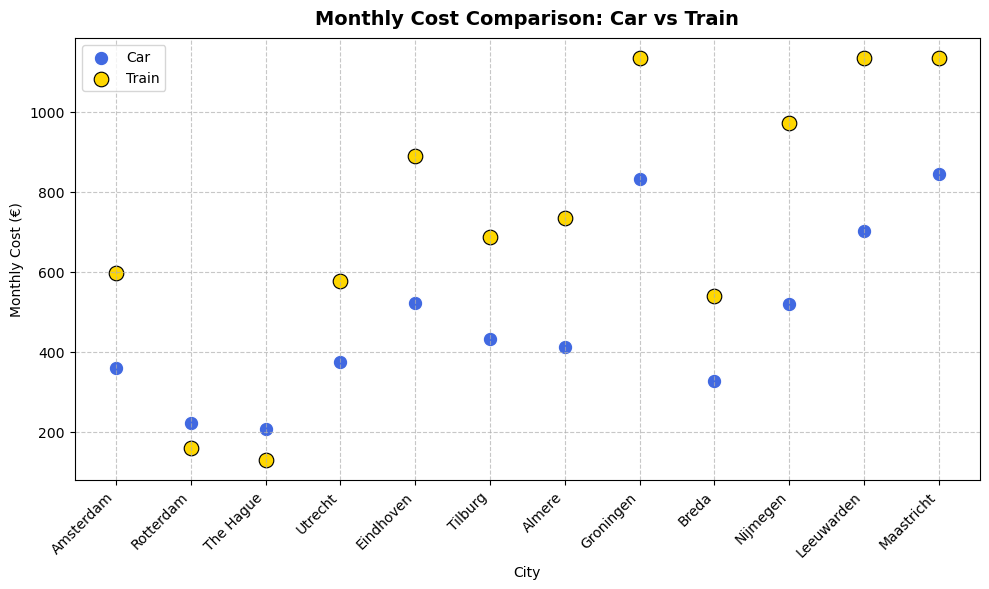

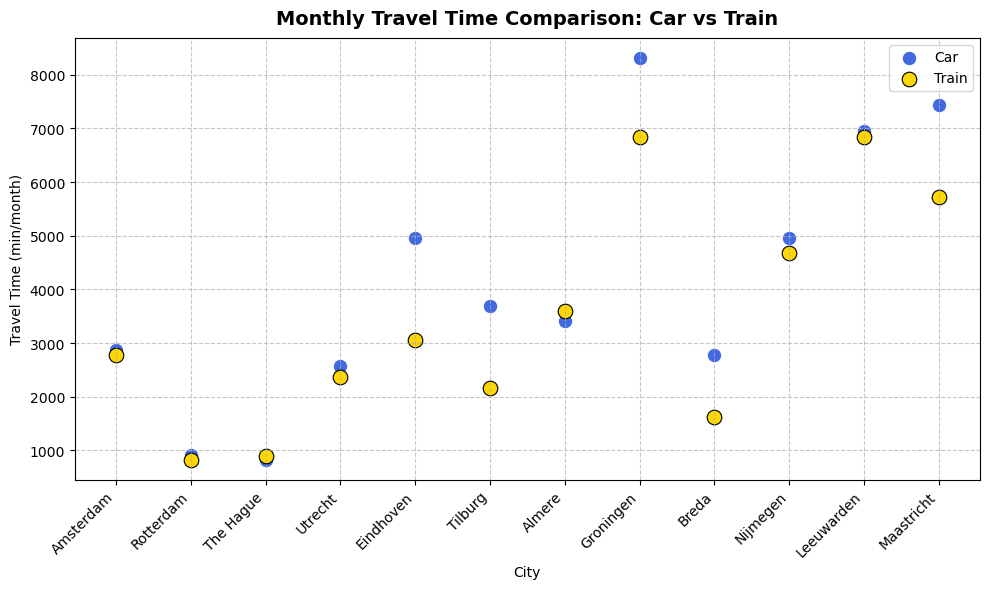

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data ---
car = pd.read_csv("../data/CarCostTime_tidy.csv")  # City,CarCost_EUR_per_month,CarTime_min_per_month
train = pd.read_csv("../data/train_monthly_summary.csv")  # city,time_per_month_min,cost_per_month_eur

# --- Standardize column names ---
car.columns = ["City_car", "CarCost_EUR_per_month", "CarTime_min_per_month"]
train.columns = ["City_train", "TrainTime_min_per_month", "TrainCost_EUR_per_month"]

# --- Create a normalized city key to join on ---
def normalize_city(s: str) -> str:
    s = s.strip()
    # map long station names to short city names
    mapping = {
        "Amsterdam Centraal": "Amsterdam",
        "Rotterdam Centraal": "Rotterdam",
        "Den Haag Centraal": "The Hague",
        "Utrecht Centraal": "Utrecht",
        "Eindhoven Centraal": "Eindhoven",
        "Tilburg Centraal": "Tilburg",
        "Almere Centrum": "Almere",
        "Groningen Centraal": "Groningen",
        "Breda Centraal": "Breda",
        "Nijmegen Centraal": "Nijmegen",
        "Leeuwarden Centraal": "Leeuwarden",
        "Maastricht Centraal": "Maastricht",
    }
    return mapping.get(s, s)

car["City"] = car["City_car"].apply(normalize_city)
train["City"] = train["City_train"].str.strip()

# --- Ensure numeric types (in case they were read as strings) ---
for col in ["CarCost_EUR_per_month", "CarTime_min_per_month"]:
    car[col] = pd.to_numeric(car[col], errors="coerce")
for col in ["TrainTime_min_per_month", "TrainCost_EUR_per_month"]:
    train[col] = pd.to_numeric(train[col], errors="coerce")

# --- Merge ---
df = pd.merge(car[["City", "CarCost_EUR_per_month", "CarTime_min_per_month"]],
              train[["City", "TrainTime_min_per_month", "TrainCost_EUR_per_month"]],
              on="City", how="inner")

# Optional: check what matched
# print(df[["City"]])

# ========= Plot 1: Cost comparison (Car vs Train) =========
plt.figure(figsize=(10, 6))
sns.scatterplot(x="City", y="CarCost_EUR_per_month", data=df, s=110, color="royalblue", label="Car")
sns.scatterplot(x="City", y="TrainCost_EUR_per_month", data=df, s=110, color="gold", edgecolor="black", label="Train")
plt.title("Monthly Cost Comparison: Car vs Train", fontsize=14, weight="bold", pad=10)
plt.ylabel("Monthly Cost (€)")
plt.xlabel("City")
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# ========= Plot 2: Time comparison (Car vs Train) =========
plt.figure(figsize=(10, 6))
sns.scatterplot(x="City", y="CarTime_min_per_month", data=df, s=110, color="royalblue", label="Car")
sns.scatterplot(x="City", y="TrainTime_min_per_month", data=df, s=110, color="gold", edgecolor="black", label="Train")
plt.title("Monthly Travel Time Comparison: Car vs Train", fontsize=14, weight="bold", pad=10)
plt.ylabel("Travel Time (min/month)")
plt.xlabel("City")
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()



📍 Intersection point at ≈ 930 min/month, €220


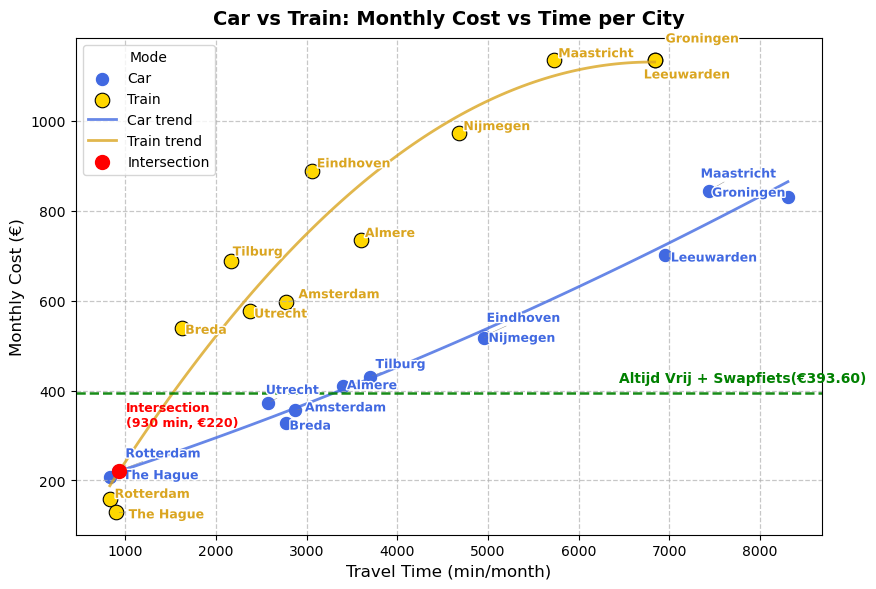

In [15]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe
import numpy as np

fig, ax = plt.subplots(figsize=(9, 6))

# --- Scatter points ---
ax.scatter(
    df["CarTime_min_per_month"], df["CarCost_EUR_per_month"],
    s=110, color="royalblue", edgecolors="white", linewidth=0.8, label="Car"
)
ax.scatter(
    df["TrainTime_min_per_month"], df["TrainCost_EUR_per_month"],
    s=110, color="gold", edgecolors="black", linewidth=0.8, label="Train"
)

p_car = np.poly1d(np.polyfit(df["CarTime_min_per_month"], df["CarCost_EUR_per_month"], 2))
x_car_line = np.linspace(df["CarTime_min_per_month"].min(), df["CarTime_min_per_month"].max(), 100)
ax.plot(x_car_line, p_car(x_car_line), color="royalblue", linewidth=2, alpha=0.8, label="Car trend")

# Train trend (polynomial curve)
p_train = np.poly1d(np.polyfit(df["TrainTime_min_per_month"], df["TrainCost_EUR_per_month"], 2))
x_train_line = np.linspace(df["TrainTime_min_per_month"].min(), df["TrainTime_min_per_month"].max(), 100)
ax.plot(x_train_line, p_train(x_train_line), color="goldenrod", linewidth=2, alpha=0.8, label="Train trend")
# ----------------------------------------------------------------
# 🔹 Find intersection point of the two curves
# ----------------------------------------------------------------
# The intersection happens when p_car(x) = p_train(x)
coeff_diff = np.polysub(p_car, p_train)  # subtract polynomials
roots = np.roots(coeff_diff)              # find where they cross

# Pick only real intersections within your time range
x_intersects = [x for x in roots if np.isreal(x) and 
                min(x_car_line.min(), x_train_line.min()) < x < max(x_car_line.max(), x_train_line.max())]

if x_intersects:
    x_int = np.real(x_intersects[0])
    y_int = p_car(x_int)
    ax.scatter(x_int, y_int, color="red", s=100, zorder=5, label="Intersection")
    ax.text(x_int + 80, y_int + 100,
            f"Intersection\n({x_int:.0f} min, €{y_int:.0f})",
            fontsize=9, color="red", weight="bold")
    print(f"📍 Intersection point at ≈ {x_int:.0f} min/month, €{y_int:.0f}")
else:
    print("No intersection found within the data range.")
# ----------------------------------------------------------------

# --- Collect labels for adjustment ---
texts = []
for _, r in df.iterrows():
    city = str(r["City"])

    # --- Car label (normal) ---
    texts.append(
        ax.text(
            r["CarTime_min_per_month"], r["CarCost_EUR_per_month"], city,
            fontsize=9, color="royalblue", weight="bold",
            path_effects=[pe.withStroke(linewidth=2, foreground="white")]
        )
    )

    # --- Train label (offset only for Groningen / Leeuwarden) ---
    tx = r["TrainTime_min_per_month"]
    ty = r["TrainCost_EUR_per_month"]

    lower = city.lower()
    if lower.startswith("groningen"):
        tx += 120   # move right
        ty += 40    # move up
        fixed_train = True
    elif lower.startswith("leeuwarden"):
        tx -= 120   # move left
        ty -= 40    # move down
        fixed_train = True
    else:
        fixed_train = False

    train_text = ax.text(
        tx, ty, city,
        fontsize=9, color="goldenrod", weight="bold",
        path_effects=[pe.withStroke(linewidth=2, foreground="white")]
    )

    # Only let adjust_text move labels that are NOT manually fixed
    if not fixed_train:
        texts.append(train_text)

# --- Automatically adjust text to avoid overlap ---
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="gray", lw=0.3), ax=ax)

# --- Styling ---
ax.set_title("Car vs Train: Monthly Cost vs Time per City", fontsize=14, weight="bold", pad=10)
ax.set_xlabel("Travel Time (min/month)", fontsize=12)
ax.set_ylabel("Monthly Cost (€)", fontsize=12)
ax.grid(True, linestyle="--", linewidth=0.9, alpha=0.7)
ax.legend(title="Mode", fontsize=10)
# Add a horizontal reference line at €393.60 (Altijd Vrij)
ax.axhline(
    y=393.60, color='green', linestyle='--', linewidth=1.8, alpha=0.9, label="Altijd Vrij"
)

# Add label text near the left side of the line
ax.text(
    ax.get_xlim()[0] + 6000, 393.60 + 25,  # position label slightly above line
    "Altijd Vrij + Swapfiets(€393.60)",
    color='green', fontsize=10, fontweight='bold'
)

fig.tight_layout()
plt.show()




This graph compares monthly travel cost (€) and time (minutes/month) for cars (blue) and trains (yellow) across cities. The trends show that train travel is cheaper for shorter commutes, but costs rise steeply with longer distances, while car costs increase more gradually. The two modes intersect around 930 minutes/month and €220, marking the break-even point: below it, trains are more economical; beyond it, cars become cheaper overall. This suggests trains are ideal for short urban trips, whereas cars offer better cost efficiency for longer commutes.